## **This notebook is an example for your intro interpretability projects for the coming weekend. I will create a basic CNN model for image classification on the Fashion-MNIST dataset, train it, and then use a couple interpretability functions to assess its performance. At the end of this tutorial, you can choose 1-2 interesting interpretability methods and test your own model!** bold text

In [ ]:
!pip install captum

import captum
import captum.attr as attr
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.0 MB/s eta 0:00:00


Specify a folder that you would like to store the training data in as "path"

In [ ]:
path = "/Users/ajfor/Documents"
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
])
training_data = torchvision.datasets.MNIST(
    root= path,
    train=True,
    download=True,
    transform= image_transform
)

testing_data = torchvision.datasets.MNIST(
    root= path,
    train=False,
    download=True,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
)

train_dl = DataLoader(training_data, batch_size=64, shuffle=True)
test_dl = DataLoader(testing_data, batch_size=1024, shuffle=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 38.0MB/s]


Extracting /Users/ajfor/Documents/MNIST/raw/train-images-idx3-ubyte.gz to /Users/ajfor/Documents/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.36MB/s]

Extracting /Users/ajfor/Documents/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/ajfor/Documents/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.15MB/s]


Extracting /Users/ajfor/Documents/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/ajfor/Documents/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.11MB/s]


Extracting /Users/ajfor/Documents/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/ajfor/Documents/MNIST/raw



Model is a simple CNN architecture.

In [ ]:
class image_classifier(nn.Module):
    def __init__(self):
        super(image_classifier, self).__init__()
        self.convBlock = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels = 16, kernel_size=5, stride = 1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride = 1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.convBlock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride = 1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.convBlock(x)
        x = self.convBlock2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

model = image_classifier().to("cpu")

Training loop

In [ ]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
pbar_epoch = tqdm(range(num_epochs))
for epoch in range(num_epochs):
    total_train = 0
    correct_train = 0
    pbar_batch = tqdm(range(len(train_dl)))
    for batch, (images, labels) in enumerate(train_dl):
        images = images.to("cpu")
        labels = labels.to("cpu")
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_train += labels.size(0)
        _, predicted = torch.max(output.data, 1)
        correct_train += (predicted == labels).sum().item()
        pbar_batch.set_description(f"Batch {batch+1}/{len(train_dl)}")
        pbar_batch.update(1)
    pbar_batch.close()

    train_accuracy = 100 * correct_train / total_train
    print(f"Train Accuracy: {train_accuracy}% \n")
    pbar_epoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
    pbar_epoch.update(1)
pbar_epoch.close()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Train Accuracy: 69.1% 



  0%|          | 0/938 [00:00<?, ?it/s]

Train Accuracy: 92.87833333333333% 



  0%|          | 0/938 [00:00<?, ?it/s]

Train Accuracy: 94.24666666666667% 



  0%|          | 0/938 [00:00<?, ?it/s]

Train Accuracy: 94.44% 



  0%|          | 0/938 [00:00<?, ?it/s]

Train Accuracy: 94.88% 



Model Eval

In [ ]:
model.eval()
total = 0
correct = 0
pbar = tqdm(range(len(test_dl)))
for batch, (images, labels) in enumerate(test_dl):
    images = images.to("cpu")
    labels = labels.to("cpu")
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    pbar.set_description(f"Batch {batch+1}/{len(test_dl)}")
    pbar.update(1)

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")
pbar.close()

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 89.32%


Interpretability

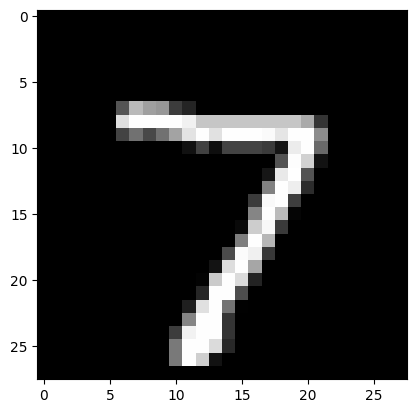

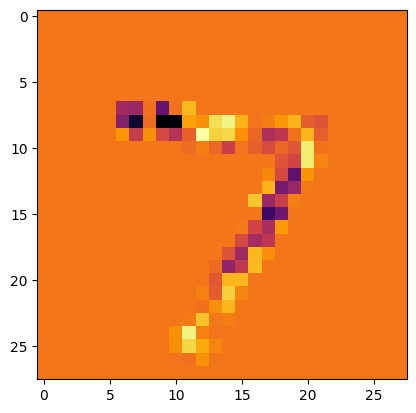

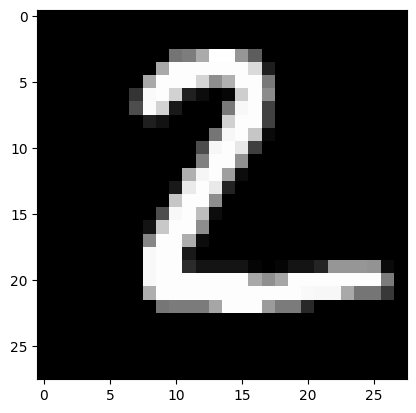

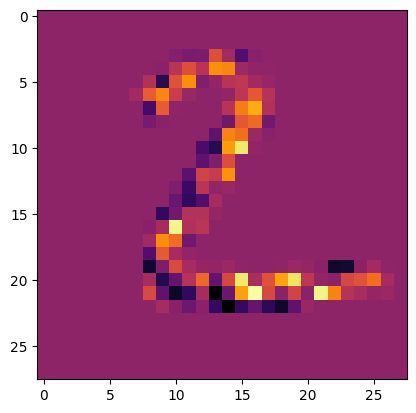

In [ ]:
ig = attr.IntegratedGradients(model)
_, label = testing_data[0]
test_sample = testing_data[0][0].unsqueeze(0).to("cpu")
test_sample2 = testing_data[1][0].unsqueeze(0).to("cpu")
plt.imshow(test_sample.squeeze().cpu().detach().numpy(), cmap='gray')
plt.show()
test_sample.requires_grad_()
attributions_ig = ig.attribute(test_sample, target=9)
plt.imshow(attributions_ig.squeeze().cpu().detach().numpy(), cmap='inferno')
plt.show()
plt.imshow(test_sample2.squeeze().cpu().detach().numpy(), cmap='gray')
plt.show()
attributions_ig2 = ig.attribute(test_sample2, target=testing_data[1][1])
plt.imshow(attributions_ig2.squeeze().cpu().detach().numpy(), cmap='inferno')
plt.show()

